In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import data_loader
import matplotlib.pyplot as plt

In [2]:
class SeriesPredictor(object):

    def __init__(self, input_dim, seq_size, hidden_dim , batch_size):
        # Hyperparameters
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.x = tf.placeholder(tf.float32, [None , seq_size, input_dim])
        self.y = tf.placeholder(tf.float32, [None , seq_size])
        
        # Weight variables and input placeholders        
        self.W_out = tf.get_variable(initializer = tf.random_normal([hidden_dim , 1]) , 
                                     name = 'w_out')
        self.b_out = tf.get_variable(initializer = tf.random_normal([1]) , 
                                     name = 'b_out')
       
        with tf.variable_scope('bulid_rnn_network'):
            self.build_network()
        
        with tf.variable_scope('cost'):
            self.cost()
    
    @staticmethod
    # 一定要這樣寫，否則會因為"self.x的維度不等於self.hidden_dim"而報錯
    # 如果不想這樣寫的話，可以把self.x丟到rnn cell之前先經過一個全連接層，使self.x的輸出跟self.hidden_dim一樣。
    def lstm_cell(hidden_size): 
        cell = tf.contrib.rnn.LSTMCell(hidden_size , use_peepholes = True)
        return cell
    
    def build_network(self):
        mlstm_cell = tf.contrib.rnn.MultiRNNCell([self.lstm_cell(self.hidden_dim) for _ in range(2)] , 
                                                 state_is_tuple = True) 
        
        self.init_state = mlstm_cell.zero_state(self.batch_size , dtype = tf.float32)
        
        self.outputs, self.states = tf.nn.dynamic_rnn(mlstm_cell , 
                                                      inputs = self.x ,
                                                      initial_state = self.init_state , 
                                                      dtype = tf.float32)
       
        self.out = tf.matmul(tf.reshape(self.outputs , [-1 , self.hidden_dim]) , self.W_out) + self.b_out
       
        self.out = tf.reshape(self.out , [-1 , self.seq_size])
    
    def cost(self):       
        weight_bias = []
        for i in tf.trainable_variables():
            weight_bias.append(i)
        
        # 加上regularization，防止overfitting
        regularization = tf.zeros([])
        for i in range(0 , len(weight_bias)):
            regularization += tf.reduce_mean(tf.square(weight_bias[i]))
        
        self.cost = tf.reduce_mean(tf.square(self.out - self.y)) + 0.0005 * regularization
        self.train_op = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(self.cost)

In [3]:
seq_size = 5
predictor = SeriesPredictor(input_dim = 1,
                            seq_size = seq_size , 
                            hidden_dim = 10 ,
                            batch_size = 110) 

In [4]:
# load data
data = data_loader.load_series('international-airline-passengers.csv')
train_data , test_data = data_loader.split_data(data)

# prepare train_data(利用錯位的概念)
# source_x : V1 V2 V3 V4 V5 
# target_y : V2 V3 V4 V5 V6 
source_x , target_y = [] , []
for i in range(len(train_data) - seq_size - 1):
    temp_x = np.array(train_data[i : i + seq_size]).reshape(-1 , 1)
    source_x.append(temp_x)
    temp_y = np.array(train_data[i + 1 : i + seq_size + 1])
    target_y.append(temp_y)
source_x = np.array(source_x)  
target_y = np.array(target_y)  

# prepare test_data(利用錯位的概念)
# test_x : V1 V2 V3 V4 V5 
# test_y : V2 V3 V4 V5 V6 
test_x , test_y = [] , []
for i in range(len(test_data) - seq_size - 1):
    temp_x = np.array(test_data[i : i + seq_size]).reshape(-1 , 1)
    test_x.append(temp_x)
    temp_y = np.array(test_data[i + 1 : i + seq_size + 1])
    test_y.append(temp_y)
test_x = np.array(test_x)  
test_y = np.array(test_y)  

In [5]:
# start to train
sess = tf.Session() 
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

max_patience = 5
patience = max_patience
min_train_err = float('inf')
step = 0
while patience > 0:    
    feed_dict = {predictor.x: source_x , predictor.y: target_y}    
    sess.run(predictor.train_op , feed_dict)
    train_err = sess.run(predictor.cost , feed_dict)
    
    if step % 100 == 0:
        print('step: {}\t\ttrain err: {}'.format(step, train_err))
        # 這裡的概念 : cost持續變小代表還沒收斂，
        # 但只要cost在下一步變大，代表可能已經開始收斂，這裡規定變大max_patience就停止訓練
        if train_err < min_train_err: 
            min_train_err = train_err
            patience = max_patience
        else:
            patience -= 1
    step += 1
    
    if step > 3500:
        break
        
# save model    
save_path = saver.save(sess, './model/rnn_net')
print('Model saved to {}'.format(save_path))        

step: 0		train err: 0.5938550233840942
step: 100		train err: 0.0424935407936573
step: 200		train err: 0.04063469544053078
step: 300		train err: 0.03956945985555649
step: 400		train err: 0.03819872438907623
step: 500		train err: 0.03629080578684807
step: 600		train err: 0.03356051817536354
step: 700		train err: 0.03042224422097206
step: 800		train err: 0.027849044650793076
step: 900		train err: 0.026320915669202805
step: 1000		train err: 0.0253322571516037
step: 1100		train err: 0.024553323164582253
step: 1200		train err: 0.02380693517625332
step: 1300		train err: 0.023224256932735443
step: 1400		train err: 0.02269248105585575
step: 1500		train err: 0.02214909717440605
step: 1600		train err: 0.021678637713193893
step: 1700		train err: 0.021345242857933044
step: 1800		train err: 0.02095227688550949
step: 1900		train err: 0.020630156621336937
step: 2000		train err: 0.020343810319900513
step: 2100		train err: 0.020094333216547966
step: 2200		train err: 0.019867468625307083
step: 2300		trai

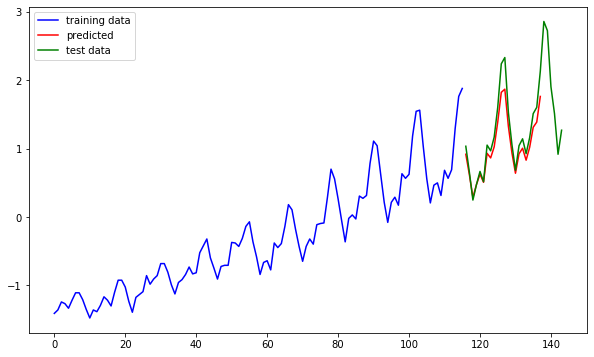

In [6]:
# 看一下測試結果
tf.get_variable_scope().reuse_variables()
seq_size = 5
predictor_test = SeriesPredictor(input_dim = 1,
                                 seq_size = seq_size , 
                                 hidden_dim = 10 ,
                                 batch_size = 22) 
predicted_vals = sess.run(predictor_test.out , feed_dict = {predictor_test.x : test_x})
predictions = predicted_vals[: , 0]

fig = plt.figure(figsize = (10 , 6)) 
num_train = len(train_data)
plt.plot(list(range(0 , num_train)) , train_data , color = 'b' , label = 'training data')
plt.plot(list(range(num_train , num_train + len(predictions))), predictions , color = 'r' , label = 'predicted')
plt.plot(list(range(num_train , num_train + len(test_data))) , test_data , color = 'g', label = 'test data')
plt.legend()